## Running the model

In [2]:
import pickle
with open('dataset2/raw_dataset_final.pickle', 'rb') as handle:
    dataset_without_id = pickle.load(handle)

In [3]:
dataset_without_id.shape

# we need to predict col 22

(1578154, 29)

In [4]:
# for one hot encoding

one_hot = {}

for j in range(dataset_without_id.shape[1]):
    
    k = dataset_without_id[:,j]
    
    encoding = {}
    tmp = 0
    for i in k:
        if i not in encoding.keys():
            encoding[i] = tmp
            tmp+=1
    one_hot[j] = encoding

In [5]:
classes = list(set(dataset_without_id[:,21]))
classes

['SERO', 'Citation', 'Warning', 'ESERO']

In [6]:
classes_dic = {}

tmp = dataset_without_id[:,21]

for i in tmp:
    if i not in classes_dic.keys():
        classes_dic[i] = 1
    else:
        classes_dic[i]+=1

In [7]:
classes_dic

{'ESERO': 75974, 'Warning': 789812, 'Citation': 711469, 'SERO': 899}

dict_keys(['ESERO', 'Warning', 'Citation', 'SERO'])
dict_values([75974, 789812, 711469, 899])


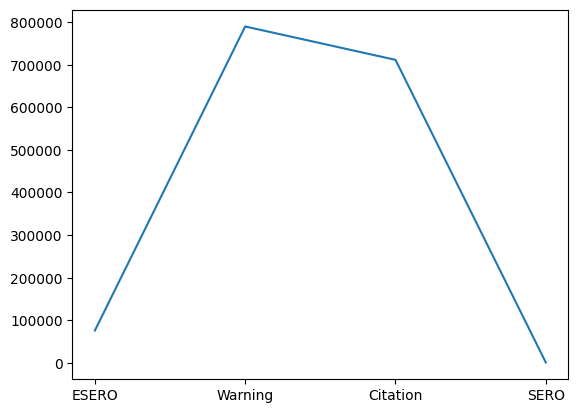

In [8]:
import matplotlib.pyplot as plt
import numpy as np

x = classes_dic.keys()
y = classes_dic.values()

print(x)
print(y)

plt.plot(x, y)
plt.show()

In [13]:
train_per = 60
val_per = 40
test_per = 100 - train_per
threshold = 5

In [10]:
classes_dic_data = {}

tmp = dataset_without_id[:,:]


for i in tmp:
    if i[21] not in classes_dic_data.keys():
        classes_dic_data[i[21]] = []
    
    classes_dic_data[i[21]].append(i)

In [11]:
for i in classes_dic_data.keys():
    print(i, len(classes_dic_data[i]))

ESERO 75974
Warning 789812
Citation 711469
SERO 899


In [14]:
import sklearn
import sklearn.model_selection

test = []
train = []
val = []


import random

for i in classes_dic_data.keys():
    
    print(i, len(classes_dic_data[i]))
    
    if len(classes_dic_data[i]) < threshold:
        
        for j in classes_dic_data[i]:
            train.append(j)
            
    else:

        train_tt, test_t = sklearn.model_selection.train_test_split(classes_dic_data[i], shuffle=True, test_size = test_per/100)
        
        train_t, val_t = sklearn.model_selection.train_test_split(train_tt, shuffle=True, test_size = val_per/100)
        
        for j in train_t:
            train.append(j)
        
        for j in test_t:
            test.append(j)
        
        for j in val_t:
            val.append(j)


ESERO 75974
Warning 789812
Citation 711469
SERO 899


In [15]:
print("Train",len(train))
print("Test",len(test)) 
print("Val",len(val))
print("Total", len(train)+len(test)+len(val)) # 2916697

Train 568133
Test 631263
Val 378758
Total 1578154


In [16]:
train = np.array(train)
test = np.array(test)
val = np.array(val)

In [18]:
for i in range(train.shape[1]):
    cl = i
    dt = train[:,i]
    for j in range(dt.shape[0]):
        train[j][i] = one_hot[i][train[j][i]]

In [19]:
for i in range(test.shape[1]):
    cl = i
    dt = test[:,i]
    for j in range(dt.shape[0]):
        test[j][i] = one_hot[i][test[j][i]]

In [20]:
for i in range(val.shape[1]):
    cl = i
    dt = val[:,i]
    for j in range(dt.shape[0]):
        val[j][i] = one_hot[i][val[j][i]]

In [21]:
train_X = np.delete(train,21,axis=1)
train_y = train[:,21]
test_X = np.delete(test,21,axis=1)
test_y = test[:,21]
val_X = np.delete(val,21,axis=1)
val_y = val[:,21]

In [22]:
train_X = train_X.astype("int32")
train_y = train_y.astype("int32")
test_X = test_X.astype("int32")
test_y = test_y.astype("int32")
val_X = val_X.astype("int32")
val_y = val_y.astype("int32")

In [23]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)



from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

clf = TabNetClassifier(device_name=device)

clf.fit(
      train_X, 
      train_y,
      eval_set=[(val_X, val_y)],
      max_epochs = 5
)

preds = clf.predict(test_X)

/home/srajat/anaconda3/envs/col865/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu
Device used : cpu
epoch 0  | loss: 0.28093 | val_0_accuracy: 0.9385  |  0:00:48s
epoch 1  | loss: 0.21651 | val_0_accuracy: 0.93932 |  0:01:28s
epoch 2  | loss: 0.20995 | val_0_accuracy: 0.93933 |  0:02:09s
epoch 3  | loss: 0.20712 | val_0_accuracy: 0.93993 |  0:02:54s
epoch 4  | loss: 0.2056  | val_0_accuracy: 0.94001 |  0:03:35s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_val_0_accuracy = 0.94001
Best weights from best epoch are automatically used!


### 1. training the model

In [24]:
print(clf.predict([test_X[0]]))
print(test_y[0])

[0]
0


### 2. testing the model

In [25]:
true_res = 0

res = clf.predict(test_X)

In [26]:
res

array([0, 2, 0, ..., 3, 3, 3], dtype=int32)

In [27]:
for i in range(res.shape[0]):
    if(res[i] == test_y[i]):
        true_res +=1

accuracy = true_res/test_X.shape[0]
print(accuracy)

0.9405065717458492


### checking if we get right

In [34]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5,5))
    #plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("fig_d2_tabnet.png")
    plt.show()

In [29]:
classes = list(set(test_y))

dic = {}
for i in range(len(classes)):
    dic[classes[i]] = i

cnf_array = []
for i in range(len(classes)):
    cnf_array.append([0]*len(classes))

for i in range(res.shape[0]):
    cnf_array[dic[test_y[i]]][dic[res[i]]]+=1

In [30]:
print(cnf_array)

[[21574, 5509, 3164, 143], [719, 289937, 25269, 0], [1103, 1640, 281845, 0], [2, 0, 7, 351]]


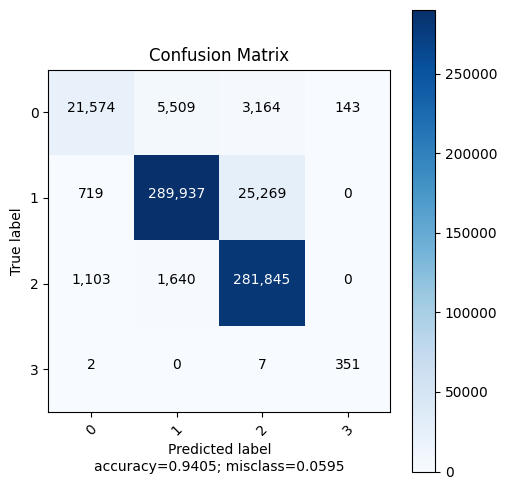

In [35]:
plot_confusion_matrix(cm= np.array(cnf_array), 
                      normalize    = False,
                      target_names = classes,
                      title        = "Confusion Matrix")